<img src="materials/images/introduction-to-imaging-cover.png"/>

# Why do we need to study medical imaging?
Though medical imaging is more than radiology, there is simply a vast shortage of radiologists. The demand for medical imaging increases as the world population ages and raises their quality of live, but the number of radiologists isn't growing to meet that demand. For example, from "2010 to 2020, the number of Diagnostic Radiology trainees ...increased just 2.5% compared to a 34% increase in the number of adults over 65" (rsna.org [article](https://https://www.rsna.org/news/2022/may/Global-Radiologist-Shortage)). 

In short, the radiologists of tomorrow will depend on AI assistance to meet demand for imaging diagnoses. More importantly, the radiologists of today already need a hand. Burnout rates among radiologists are increasing and regions with few or small urban centers are particularly feeling their diagnostic radiology needs unmet (acr.org [article](https://www.acr.org/Practice-Management-Quality-Informatics/ACR-Bulletin/Articles/March-2022/The-Radiology-Labor-Shortage)).

# What are the categories?
Radiology is but one type of medical imaging, and even then it is a broad field. Radiology includes X-Rays, CT (computed axial tomography), MRI (magnetic resonance imaging), Ultrasound, Fluoroscopy, and more. And beyond radiology, many medical tests include microscopic analysis of blood ans other tissues.

# Why is it important?
Technology directed at aiding diagnoses and healthcare actions based on medical imaging can improve the quality of medical care. The time efficiency of computers can also lower the costs to this care and make it available to greater numbers of people. Furthermore, the technology necessary for making these impacts is available and the methods for its construction are public knowledge.

# What are the major applications? 
AI/ML methods for medical imaging can speed up response time to patients, improve and standarize accuracy, and enable hospitals in remote regions with limited resources to have their images read.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import time
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

Matplotlib is building the font cache; this may take a moment.
2023-01-12 00:52:00.762468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

# Load data

We're going to load in **CIFAR10**, a massive dataset with low resolution images in 10 categories. It's perfect for learning to build classifying ML models.

In [2]:
data = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


The categories are below, they're numbers in the dataset, so let's also keep track of the actual words

In [3]:
lbls_str = ("airplane automobile bird cat deer dog frog horse ship truck")

In [4]:
lbls_lst = lbls_str.split()
lbls_lst

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
(x_train, y_train), (x_test, y_test) = data

There are 50k training images and 10k testing images, but we'll use only a few thousand so tests can be quick.

In [6]:
for arr in [x_train, y_train, x_test, y_test ]:
    print(arr.shape)

(50000, 3, 32, 32)
(50000, 1)
(10000, 3, 32, 32)
(10000, 1)


This histogram is a good idea because the training set's distribution should match the validation set's, and the validation set's should ABSOLUTELY match the test set's.

The splicing of the y_train below is a result of trying many different intervals, searching for histograms with more or less equal representation of all classes.

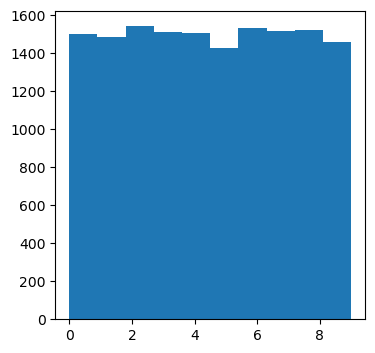

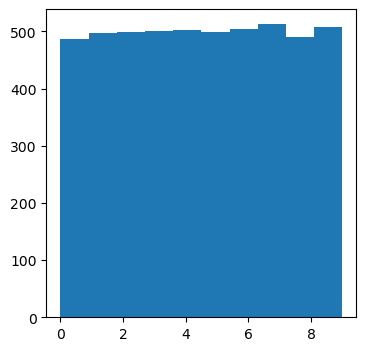

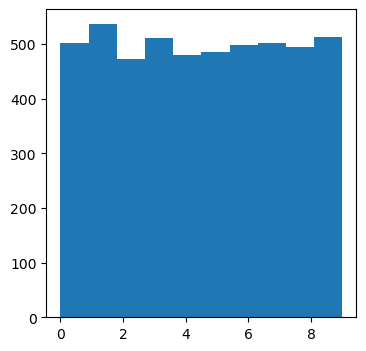

In [7]:
plt.figure(figsize=(4,4));
plt.hist(y_train[:15000]);

plt.show()
plt.figure(figsize=(4,4));
plt.hist(y_train[15000:20000]);

plt.show()
plt.figure(figsize=(4,4));
plt.hist(y_train[20000:25000]);

plt.show()

This function will give us one hot vectors from the number corresponding to the classes, we know that  0 = airplane and 3 = cat, but the ML will have a better time if we have one hot vectors like <1,0,0,0,0,0,0,0,0,0> or <0,0,0,1,0,0,0,0,0,0>

In [8]:
def one_hot(vec):
    n = vec.shape[0]
    out = np.zeros((n, np.max(vec)+1))
    for i in range(n):
        out[i,vec[i][0]]=1
    return out

Let's look at an example to learn about `one-hot`.

In [9]:
one_hot(np.array([[3],[5],[3],[0],[2],[1]]))

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

Using the intervals from earlier, we'll define a training, validation and testing set. We'll translate this short array of indices (3,5,3,0,2,1) into a one hot matrix where the position of the '1' in each row communicates its index.

In [10]:
xtr, xval, xtst = (np.transpose(x_train[:2000], (0,2,3,1)),
                   np.transpose(x_train[4500:5500], (0,2,3,1)),
                   np.transpose(x_train[5500:6500], (0,2,3,1)))
ytr, yval, ytst = y_train[:2000],y_train[4500:5500],y_train[5500:6500]

(2000, 32, 32, 3) (2000, 1)


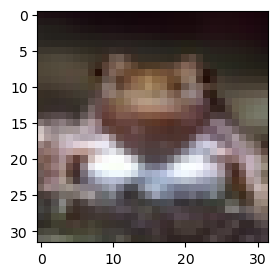

frog
(1000, 32, 32, 3) (1000, 1)


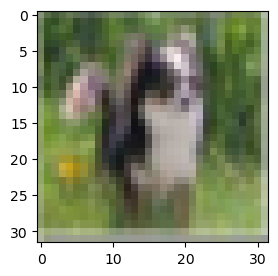

dog
(1000, 32, 32, 3) (1000, 1)


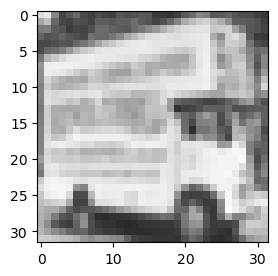

truck


In [11]:
for k in [(xtr,ytr),(xval,yval),(xtst,ytst)]:
    print(k[0].shape,k[1].shape)
    im = np.random.randint(0,500)
    #NOTE THAT THE IMAGES ARE 32 BY 32 BY 3 ARRAYS
    plt.figure(figsize=(3,3))
    plt.imshow(k[0][im])
    plt.show()
    print(lbls_lst[k[1][im][0]])

It's always a good idea to save your work.

Note that there are validation and test sets: 

**Validation sets** are used to have your trained model predict on, and thus get an idea for its performance on 'unseen data' (data that the model didn't train on). This way, validation sets and their respective accuracy guide one's selection of hyperparameters and architectures. 

**Test sets** are never touched until the very end to give a final estimate of your model's performance on unseen data.

In [12]:
vtr,vval,vtst = one_hot(ytr),one_hot(yval),one_hot(ytst)
np.save('xtr',xtr)
np.save('vtr',vtr)
np.save('xval',xval)
np.save('vval',vval)
np.save('xtst',xtst)
np.save('vtst',vtst)

---

## Let's build some AI models with this data

In [13]:
print('our whole training data has shape: ',xtr.shape)
print('\nand our training set of labels haa shape: ',vtr.shape)

our whole training data has shape:  (2000, 32, 32, 3)

and our training set of labels haa shape:  (2000, 10)


We can start with a basic neural net, a function will help so we can make the AI model whenever and we don't have to copy code

In [14]:
def generate_basic_model(input_shape = xtr[0].shape):
    
    input_tensor = tf.keras.Input(shape=input_shape )
    #keras likes tensors
    #BTW A TENSOR IS ANY ARRAY AND OFTEN REFERS TO ARRAYS WITH MORE THAN 2 AXES 
    #e.g.:  rows, columns, color channels (RGB)
    #vectors are groups of number, matrices are groups of vectors, 
    #tensors are groups of matrices (or other tensors)
    #there's no need to be afraid of tensors
  
    flat= Flatten()(input_tensor)
    #neural nets like flat input, notice how the result of one line 
    #is the input to the next
    
    FC1 = Dense(64, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(flat)
    #cool kids use regularization
    #regularization helps prevent overfitting
    
    # Note that the relu activation function is often used. It has been the
    # bread and butter of machine learning projects for years.

    FC2 = Dense(32, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC1) 

    FC3 = Dense(16, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC2) 
    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC3)
    
    # Note that the softmax activation function is added at the end. This 
    # is a function that turns an array of values into a group of probabilities.
    # In this way, it's very useful for single class categorization tasks.
    
    
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=1e-1),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [15]:
basicAI = generate_basic_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 64)                196672    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 10)                170       
                                                                 
Total params: 199,450
Trainable params: 199,450
Non-trainable

2023-01-12 00:52:29.608942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-12 00:52:29.609009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-10-121-102.ec2.internal): /proc/driver/nvidia/version does not exist
2023-01-12 00:52:29.610112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You just made an AI model! Now let's train it.

Note that we use the variables `vtr` and `vval` for the labels. This is because the y values came as scalars.

In [16]:
basicAI.fit(xtr, vtr, validation_data = (xval,vval), epochs = 15)

Epoch 1/15
63/63 [==============================] - 1s 10ms/step - loss: 2768.6516 - accuracy: 0.0930 - val_loss: 431.5963 - val_accuracy: 0.1130
Epoch 2/15
63/63 [==============================] - 0s 7ms/step - loss: 370.0248 - accuracy: 0.0975 - val_loss: 313.7627 - val_accuracy: 0.0900
Epoch 3/15
63/63 [==============================] - 0s 8ms/step - loss: 272.1327 - accuracy: 0.1010 - val_loss: 232.9991 - val_accuracy: 0.1130
Epoch 4/15
63/63 [==============================] - 0s 8ms/step - loss: 202.6474 - accuracy: 0.0995 - val_loss: 173.9040 - val_accuracy: 0.0900
Epoch 5/15
63/63 [==============================] - 0s 6ms/step - loss: 151.5770 - accuracy: 0.1025 - val_loss: 130.4492 - val_accuracy: 0.0930
Epoch 6/15
63/63 [==============================] - 0s 8ms/step - loss: 113.9988 - accuracy: 0.1060 - val_loss: 98.4300 - val_accuracy: 0.1090
Epoch 7/15
63/63 [==============================] - 0s 8ms/step - loss: 86.3217 - accuracy: 0.0855 - val_loss: 74.8320 - val_accuracy: 

Now, let's try and predict an image's category (though accuracy is little better than chance).
Each row contains the confidence of the model in the sample being a member of a category; for example, all samples have a .1 = 10% confidence for being members of category at index 1, which is 'automobile'. 

In [17]:
np.round(basicAI.predict(xval[305:310,:,:,:]),2),vval[305:310]

1/1 [==============================] - 0s 84ms/step


(array([[0.09, 0.1 , 0.11, 0.09, 0.11, 0.09, 0.1 , 0.09, 0.1 , 0.11],
        [0.09, 0.1 , 0.11, 0.09, 0.11, 0.09, 0.1 , 0.09, 0.1 , 0.11],
        [0.09, 0.1 , 0.11, 0.09, 0.11, 0.09, 0.1 , 0.09, 0.1 , 0.11],
        [0.09, 0.1 , 0.11, 0.09, 0.11, 0.09, 0.1 , 0.09, 0.1 , 0.11],
        [0.09, 0.1 , 0.11, 0.09, 0.11, 0.09, 0.1 , 0.09, 0.1 , 0.11]],
       dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

In [18]:
xtr[0].shape

(32, 32, 3)

We might not be able to publish this model in Nature...

Let's try a convolutional neural network.

Note that errors can often be hard parts of getting started with the major machine learning libraries. It's okay. Looking up errors on Google or sites like stack overflow can provide fantastic responses, and the sites housing the libraries in question are also great (https://www.tensorflow.org/)

In [19]:
def generate_conv_model(input_shape = xtr[0].shape):
    
    input_tensor = tf.keras.Input(shape=input_shape )
    
    #the kernel size will be set to 2 by 2 pixels
    #the 4, 8, and 12 in the next layers are the channels future layers will have
    #for example, the first layer here will make 4 convolutional filters that will 
    
    REG = 1e-2
    LR = 3e-1
    
    c1 = Conv2D(8, kernel_size=(2, 2),
               
                activation='relu', 
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(REG))(input_tensor) 
    c2 = Conv2D(16, kernel_size=(2, 2),
                
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c1)
    c3 = Conv2D(32, kernel_size=(2, 2),
               
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c2)
    
    mp1 = tf.keras.layers.MaxPool2D(data_format= 'channels_last',)(c3)
    # max pooling layers can help convolutional models
    
    c4 = Conv2D(8, kernel_size=(2, 2),
                activation='relu',
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(REG))(mp1) 
    c5 = Conv2D(16, kernel_size=(2, 2),
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c4)
    c6 = Conv2D(32, kernel_size=(2, 2), 
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c5)
    
    mp2 = tf.keras.layers.MaxPool2D(data_format= 'channels_last',)(c6)
  
    flat= Flatten()(mp2) #was mp2

    
    FC1 = Dense(64, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(flat)

    FC2 = Dense(32, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(FC1) 

    FC3 = Dense(16, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(FC2) 
    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(REG))(FC3)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=LR),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [20]:
convAI = generate_conv_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 8)         104       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        528       
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 32)        2080      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 8)         1032      
                                                           

In [21]:
record = convAI.fit(xtr, vtr, validation_data = (xval,vval), epochs = 10)

Epoch 1/10
63/63 [==============================] - 5s 53ms/step - loss: 295555.6250 - accuracy: 0.1015 - val_loss: 378.9593 - val_accuracy: 0.1130
Epoch 2/10
63/63 [==============================] - 3s 51ms/step - loss: 384.8169 - accuracy: 0.0925 - val_loss: 325.1529 - val_accuracy: 0.0980
Epoch 3/10
63/63 [==============================] - 3s 50ms/step - loss: 312.4578 - accuracy: 0.1040 - val_loss: 302.6685 - val_accuracy: 0.0900
Epoch 4/10
63/63 [==============================] - 3s 50ms/step - loss: 296.2840 - accuracy: 0.0945 - val_loss: 290.3168 - val_accuracy: 0.0930
Epoch 5/10
63/63 [==============================] - 3s 49ms/step - loss: 285.5946 - accuracy: 0.1040 - val_loss: 281.0356 - val_accuracy: 0.0980
Epoch 6/10
63/63 [==============================] - 3s 53ms/step - loss: 277.2037 - accuracy: 0.1065 - val_loss: 273.4329 - val_accuracy: 0.0900
Epoch 7/10
63/63 [==============================] - 3s 50ms/step - loss: 270.2299 - accuracy: 0.0960 - val_loss: 267.0193 - val

This model also isn't fantastic. That's OK, though, testing architectures and hyperparameters is a natural step in ML/AI.

Let's explore the output of the `fit` function which we stored in the `record` variable.

In [22]:
record.history

{'loss': [295555.625,
  384.81689453125,
  312.45782470703125,
  296.2840270996094,
  285.5946350097656,
  277.20367431640625,
  270.22991943359375,
  264.25262451171875,
  259.0525207519531,
  254.4420166015625],
 'accuracy': [0.1014999970793724,
  0.0925000011920929,
  0.10400000214576721,
  0.09449999779462814,
  0.10400000214576721,
  0.10649999976158142,
  0.09600000083446503,
  0.0989999994635582,
  0.0989999994635582,
  0.09549999982118607],
 'val_loss': [378.9593200683594,
  325.15289306640625,
  302.6684875488281,
  290.3167724609375,
  281.0355529785156,
  273.43292236328125,
  267.0192565917969,
  261.4791259765625,
  256.6028137207031,
  252.23959350585938],
 'val_accuracy': [0.11299999803304672,
  0.09799999743700027,
  0.09000000357627869,
  0.09300000220537186,
  0.09799999743700027,
  0.09000000357627869,
  0.0949999988079071,
  0.11299999803304672,
  0.0949999988079071,
  0.1120000034570694]}

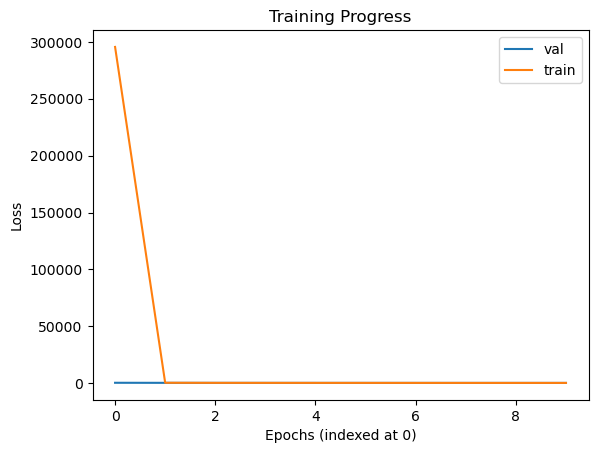

Text(0, 0.5, 'Accuracy (decimal)')

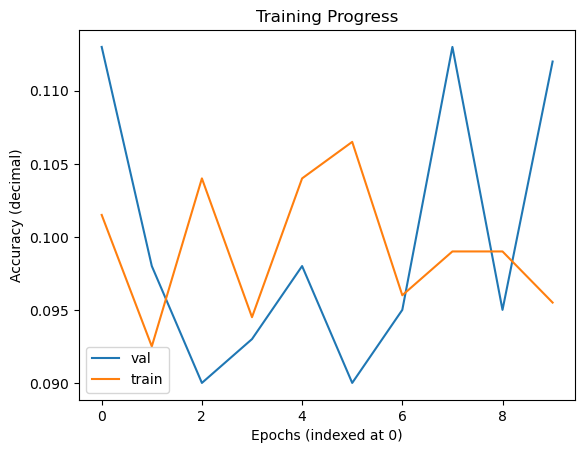

In [23]:
plt.plot(record.history['val_loss'])
plt.plot(record.history['loss'])
plt.title('Training Progress')
plt.xlabel('Epochs (indexed at 0)')
plt.ylabel('Loss')
plt.legend(['val','train'])
plt.show()
#note that we will select good models based on the performance on the 
#validation set

plt.plot(record.history['val_accuracy'])
plt.plot(record.history['accuracy'])
plt.legend(['val','train'])
plt.title('Training Progress')
plt.xlabel('Epochs (indexed at 0)')
plt.ylabel('Accuracy (decimal)')

In [24]:
def gen_model(lr =  1e-3, r = 1, input_shape = xtr[0].shape, 
              filter_size =3, fc_lst = [400,400,200], s = False):
    input_tensor = tf.keras.Input(shape=input_shape )
    """
    THIS ARCHITECTURE WAS INSPIRED BY VGG16 
    
    lr refers to learning rate
    r referes to L2 regularization rate 
    filter_size is used for vertical and horizontal dimension of all
        convolutional kernels in this model
    fc_lst defines the layers and cells following the convolutional 
        segment. For example, fc_lst = [400,200,100] will add three
        neural netowrk layers at the end of the model where the first
        has 400 cells and the last has 100 cells. 
        The final layer will always automatically have 10 cells for
        prediction and fc_lst must be a list of two or more numbers
    s takes a boolean deciding whether to print a keras summary
        of the model generated
    
    """
    c1 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                padding='same',
                activation='relu', 
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(input_tensor) 
    c2 = Conv2D(8, kernel_size=(filter_size, filter_size),
                 padding='same',
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(r))(c1)
    c3 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                 padding='same',
                activation='relu',
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(r))(c2)
    l1 = tf.keras.layers.LayerNormalization()(c3)
    c4 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu',
                 padding='same',
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(l1) 
    c5 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu',
                 padding='same',
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(r))(c4)
    c6 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu',
                 padding='same',
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(r))(c5)
    mp2 = tf.keras.layers.MaxPool2D(data_format= 'channels_last',)(c6)
    l2 = tf.keras.layers.LayerNormalization()(mp2)
    c7 = Conv2D(32, kernel_size=(filter_size, filter_size),
                activation='relu',
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(l2) 
    c8 = Conv2D(32, kernel_size=(filter_size, filter_size),
                activation='relu',
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(r))(c7)
    c9 = Conv2D(32, kernel_size=(filter_size, filter_size), 
                activation='relu',
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.L2(r))(c8)
    mp3 = tf.keras.layers.MaxPool2D(data_format= 'channels_last',)(c9)
    l2 = tf.keras.layers.LayerNormalization()(mp3)
    ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ##
    flat= Flatten()(l2)
    for fc_dim in fc_lst[:-1]:
        FC = Dense(fc_dim, activation = 'relu',
                    kernel_regularizer = tf.keras.regularizers.L2(r))(flat)
        flat = tf.keras.layers.LayerNormalization()(FC)
    flat = Dense(fc_lst[-1], activation = 'relu',
                    kernel_regularizer = tf.keras.regularizers.L2(r))(flat)    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(r))(flat)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    if s:
        model.summary()
    return model

We can now easily generate different models.

Note that the summaries show 288 parameters after all the convolutions, so a number of cells much larger than that in the `fc_lst` may not be useful and could make the model slower with no benefit.

Additionally, `filter_size` values above 4 will crash the model as the initial pixel count of 32 is too small to last through 9 such convolutions and a pair of max pooling layers

In [25]:
for fc_lst in [[200,200,200],[100,100],[200,150,150,50,50]]:
    model =gen_model(fc_lst = fc_lst,s=True)
    print('\n\n')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 layer_normalization (LayerN  (None, 32, 32, 8)        16        
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        1168      
                                                           

In [26]:
xtr.shape, xval.shape

((2000, 32, 32, 3), (1000, 32, 32, 3))

In [ ]:
for fc_lst in [[128,128,128],[64,64,32,16]]:
    for filter_size in [2,3]:
        for i in range(2):
            #we will train every model 3 times with different learning rate and
            #regularization hyperparameters
            LRlog = np.random.rand()*3 - 4
            REGlog = np.random.rand()*3 - 3
            #note that this rand function gives a number from a uniform distribution
            #a number from a normal distribution wouldn't be ideal
            LR = 10**(LRlog)
            REG = 10**(REGlog)
            #we're exploring the hyperparemeter space of LR and REG
            #logarithmically, so various magnitudes are equally represented
            #if we took a random number from 1e-4 to 1e-1 directly, 
            #the lower magnitudes wouldn't come up often
            model =gen_model(fc_lst = fc_lst,
                             filter_size=filter_size,
                             lr= LR, r = REG, s=True)
            print('\nMODEL (fc_lst, filter_size, LR, REG): ',
                  fc_lst, filter_size, np.round(LR,5), np.round(REG,4),
                 '\n\n')
            #the np.round() function is fantastic for the eyes
            record = model.fit(xtr,vtr,validation_data=(xval,vval), epochs = 8)
            

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 8)         104       
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 8)         264       
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 8)         264       
                                                                 
 layer_normalization_16 (Lay  (None, 32, 32, 8)        16        
 erNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 16)        528       
                                                           

---

# Now, THOSE are some GOOOOD models!! Let's build a model with medical images. 

## We'll use data from "PadChest: A large chest x-ray image dataset with multi-label annotated reports" published in Medical Image Analysis (2020) by Bustos A., Pertusa A., Salinas J., de la Iglesia-Vayá M. https://bimcv.cipf.es/bimcv-projects/padchest/

## First, we'll load the data.

In [28]:
N = 87
dim = 1200
xr_arr = np.load('resizedPadChest0.npy')
diag_arr = np.load('sickbin.npy')
xr_arr = xr_arr.reshape(N,dim,dim,1)
diag_arr = diag_arr.reshape(N,1)
print(xr_arr.shape, diag_arr.shape)

(87, 1200, 1200, 1) (87, 1)


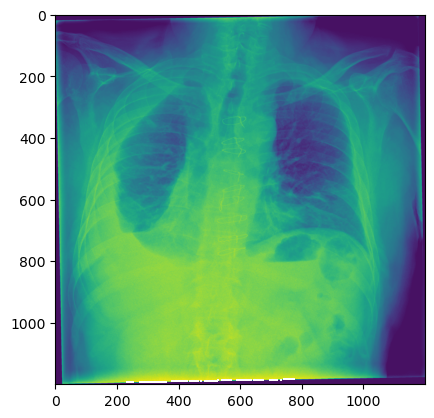

AND the matching value is  [1]  so the patient is ill. And chances are the patient would like to know...


In [29]:
plt.imshow(xr_arr[3])
plt.show()
print('AND the matching value is ',diag_arr[3], ' so the patient is ill. And chances are the patient would like to know...')

### these are 87 chest xray images with about a third of them healthy and a third of them suffering from a nondescribed ailment. We'll build a small model to try and catch abnormal images

### A 1 at location 'k' means that the image in 'xr_arr' at location 'k' is abnormal and has some visible disease

In [30]:
def gen_xr_model(lr =  1e-3, r = 1, input_shape = xr_arr[0].shape, 
              filter_size =4, fc_lst = [400,400,200], s = False):
    input_tensor = tf.keras.Input(shape=input_shape )
    """
    THIS ARCHITECTURE WAS INSPIRED BY VGG16 
    
    lr refers to learning rate
    r referes to L2 regularization rate 
    filter_size is used for vertical and horizontal dimension of all
        convolutional kernels in this model
    fc_lst defines the layers and cells following the convolutional 
        segment. For example, fc_lst = [400,200,100] will add three
        neural netowrk layers at the end of the model where the first
        has 400 cells and the last has 100 cells. 
        The final layer will always automatically have 21 cells for
        prediction and fc_lst must be a list of two or more numbers
    s takes a boolean deciding whether to print a keras summary
        of the model generated
        
    changes from earlier version of this function:
        last layer now has 21 cells and a sigmoid rather than softmax
        activation function, this allows one image to have multiple
        diagnoses. Padding was removed. default input shape changed
    
    """
    c1 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(input_tensor) 
    c2 = Conv2D(8, kernel_size=(filter_size, filter_size),
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c1)
    c3 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                activation='relu',
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c2)
    mp1 = tf.keras.layers.MaxPool2D(data_format= 'channels_last')(c3)
    l1 = tf.keras.layers.LayerNormalization()(mp1)
    c4 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(l1) 
    c5 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c4)
    c6 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c5)
    mp2 = tf.keras.layers.MaxPool2D(data_format= 'channels_last')(c6)
    l2 = tf.keras.layers.LayerNormalization()(mp2)
    c7 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(l2) 
    c8 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c7)
    c9 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c8)
    mp3 = tf.keras.layers.MaxPool2D(data_format= 'channels_last')(c9)
    l3 = tf.keras.layers.LayerNormalization()(mp3)
    c10 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                 data_format= 'channels_last',
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.l2(r))(l3) 
    c11 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                 data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c10)
    c12 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                 data_format= 'channels_last',
                kernel_regularizer = tf.keras.regularizers.l2(r))(c11)
    mp4 = tf.keras.layers.MaxPool2D(data_format= 'channels_last')(c12)
    l4 = tf.keras.layers.LayerNormalization()(mp4)
    ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ##
    flat= Flatten()(l4)
    for fc_dim in fc_lst[:-1]:
        FC = Dense(fc_dim, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.l2(r))(flat)
        flat = tf.keras.layers.LayerNormalization()(FC)
    flat = Dense(fc_lst[-1], activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.l2(r))(flat)    
    predictions = Dense(1, activation = 'sigmoid', 
                        kernel_regularizer = tf.keras.regularizers.l2(r))(flat)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    if s:
        model.summary()
    return model

In [31]:
xr_ai = gen_xr_model(lr =  1e-3, r = 1, input_shape = xr_arr[0].shape, 
              filter_size =5, fc_lst = [48,40,32], s = True)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1200, 1200, 1)]   0         
                                                                 
 conv2d_105 (Conv2D)         (None, 1196, 1196, 8)     208       
                                                                 
 conv2d_106 (Conv2D)         (None, 1192, 1192, 8)     1608      
                                                                 
 conv2d_107 (Conv2D)         (None, 1188, 1188, 8)     1608      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 594, 594, 8)      0         
 g2D)                                                            
                                                                 
 layer_normalization_60 (Lay  (None, 594, 594, 8)      16        
 erNormalization)                                         

Now, you can train this and other models to develop a strong assistant to radiologists! 

Hint: the techniques in the **CIFAR** dataset can work here!

In [ ]:
xr_ai.fit(
    x=xr_arr,
    y=diag_arr,
    batch_size=2,
    epochs=10)

Epoch 1/10
29/44 [==================>...........] - ETA: 3:48 - loss: nan - accuracy: 0.3793


---

# Contributions & acknowledgement

Thank the following team to work on this module:

- **Module Content:** David Jose Florez Rodriguez
- **Engineering:** Amit Dixit
- **UX/UI Design & Illustration:** Kexin Cha
- **Video Production:** Francesca Goncalves
- **Project Management:** Amir Bahmani, Kexin Cha

---

Copyright (c) 2022 Stanford Data Ocean (SDO)

All rights reserved.